# RMSProp練習

* http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/DNN%20tip.pdf#page=21

* Adagrad的進階版本

* alpha也是可以調整的值
* alpha的值設的小一點，意思就是說你傾向相信新的gradient，所告訴你目前error surface的平滑或陡峭程度
* alpha的值設的大一點，我比較相信過去所有gradient平方合開根號的結果

* 當你在做RMSProp的時候，你一樣是在算graident的root mean square，但是你可以給現在你新看到的gradient比較大的weight，過去看到比較小

In [2]:
#http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex2/ex2.html
%pylab inline
import theano
import theano.tensor as T
import itertools as it
import time
import pandas as pd

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

### make batches
def mk_batches(x_data, y_data, batch_size, shuffle=False):
    x_batch = list()
    y_batch = list()
    
    x_data_size = x_data.shape[0]
    y_data_size = y_data.shape[0]
    assert x_data_size == y_data_size , 'the x, y dimension is error'
    
    if shuffle:
        indices = np.arange(x_data_size)
        np.random.shuffle(indices)
    
    #range(start, stop, step)
    for start_idx in range(0, x_data_size, batch_size):
        if shuffle:
            idx = indices[start_idx : start_idx + batch_size]            
        else:
            idx = slice(start_idx, start_idx + batch_size)
            
        x_batch.append(x_data[idx])
        y_batch.append(y_data[idx])
    
    return x_batch, y_batch
    
### data
batch_size = 10
x_data = floatX(np.loadtxt('.\ex2x.dat'))
y_data = floatX(np.loadtxt('.\ex2y.dat'))


### params / init weights
w = theano.shared(floatX(-1.))
b = theano.shared(floatX(-1.))

### model
x = T.vector()
y = w*x + b

### cost/error/loss
y_hat = T.vector()
cost = T.mean((y-y_hat)**2)

###############################################################################
### gradients
his_grad_dw = []
his_grad_db = []
second_dw = theano.shared(floatX(0.))
second_db = theano.shared(floatX(0.))

def gd(params, grads, lr):
    updates = []
        
    for p, g in it.izip(params, grads):
        updates.append([p, p - lr*g])

    return updates

def Adagd(params, grads):
    updates = []
    lr = floatX(1.)
    
    updates.append([params[0], params[0] - (lr/second_dw)*grads[0]])
    
    updates.append([params[1], params[1] - (lr/second_db)*grads[1]])
    
    return updates
    
def Rmsprop(params, grads):
    updates = []
    
    lr = floatX(0.01)
    
    updates.append([params[0], params[0] - (lr/second_dw)*grads[0]])
    
    updates.append([params[1], params[1] - (lr/second_db)*grads[1]])
    
    return updates
    
dw, db = T.grad(cost, [w, b])

###############################################################################
### calculate every step gradient's root mean square
def calc_second_derivative(x, y):
    g_dw = f_grad_dw(x, y)          
    g_db = f_grad_db(x, y) 
     
    his_grad_dw.append(g_dw)
    his_grad_db.append(g_db)
    
    second_dw.set_value(floatX(np.sqrt(np.sum(np.square(his_grad_dw)))))
    second_db.set_value(floatX(np.sqrt(np.sum(np.square(his_grad_db)))))

Populating the interactive namespace from numpy and matplotlib


## 計算RMSProp sigma部分

- http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/DNN%20tip.pdf#page=22
- a (alpha)
- 當算第一次的時候，sigma0就是g0
- 之後就是算上一輪的gradient和目前的gradient平方合開根號 (因為平均這件事呢可以跟上面Learning Rate的t dependent抵銷掉，請參考adagrad筆記)
- Hinton建議alpha=0.9，Learning Rate=0.001是好的開始
- 就我這個問題的error surface，Learning Rate=0.01收斂更快


In [3]:
def calc_rms_derivative(x, y, i):
    
    # Hinton suggests alpha to be set to 0.9, while a good default value for the learning rate is 0.001.
    # 看問題而定，就我這個問題，用0.001的learning rate學很慢    
    a = 0.9
    
    g_dw = f_grad_dw(x, y)          
    g_db = f_grad_db(x, y) 
    
    if i == 0:
        his_grad_dw.append(g_dw)
        curr_sigam_dw = g_dw
        
        his_grad_db.append(g_db)
        curr_sigam_db = g_db
    else:
        pre_sigma_dw = his_grad_dw[i-1]
        curr_sigam_dw = np.sqrt ( a * np.square(pre_sigma_dw) + (1 - a) * np.square(g_dw) )
        his_grad_dw.append(curr_sigam_dw)
        
        pre_sigma_db = his_grad_db[i-1]
        curr_sigam_db = np.sqrt ( a * np.square(pre_sigma_db) + (1 - a) * np.square(g_db) )
        his_grad_db.append(curr_sigam_db)
    
    second_dw.set_value(floatX(curr_sigam_dw))    
    second_db.set_value(floatX(curr_sigam_db))

## theano function

In [4]:
###############################################################################
### theano function
f_model = theano.function([x], y)

f_cost = theano.function([x, y_hat], cost)

f_grad_dw = theano.function([x, y_hat], dw)

f_grad_db = theano.function([x, y_hat], db)

f_train = theano.function(inputs=[x, y_hat],
                          outputs=[cost, w, b],
                          updates=gd([w, b], [dw, db], 0.01))

f_train_adagd = theano.function(inputs=[x, y_hat],
                                outputs=[cost, w, b],
                                updates=Adagd([w, b], [dw, db]))

f_train_rmsprop = theano.function(inputs=[x, y_hat],
                                  outputs=[cost, w, b],
                                  updates=Rmsprop([w, b], [dw, db]))

## 跑

In [5]:
epochs = 500

## training by Sgd

In [6]:
###############################################################################
# training by gd
his_cost_by_gd = pd.DataFrame(columns=['cost', 'w', 'b'])
tStart = time.time()
for t in range(epochs):
        all_cost = 0
        all_w = 0
        all_b = 0
        
        x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
        batch_num = len(x_batches)      
            
        for i in range(batch_num):            
            tr_cost, tr_w, tr_b= f_train(x_batches[i], y_batches[i])            
            all_cost += tr_cost
        
        his_cost_by_gd.loc[t] = [all_cost/batch_num, tr_w, tr_b]

tEnd = time.time()
print '(Sgd) minimum result \n %s' % (his_cost_by_gd.loc[his_cost_by_gd['cost'].argmin()])
print 'It costs %f sec \n' % (tEnd-tStart)

(Sgd) minimum result 
 cost         0.00198043
w       0.0688982149206
b        0.729932821281
Name: 406, dtype: object
It costs 1.047000 sec 



## training by Adagrad

In [7]:
###############################################################################
# training by adagrad
w.set_value(floatX(-1.))
b.set_value(floatX(-1.))
his_grad_dw = []
his_grad_db = []
second_dw.set_value(floatX(0.))
second_db.set_value(floatX(0.))
his_cost_by_adagd = pd.DataFrame(columns=['cost', 'w', 'b'])
tStart = time.time()
for t in range(epochs):
        all_cost = 0       
        x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
        batch_num = len(x_batches)      
            
        for i in range(batch_num):
            calc_second_derivative(x_batches[i], y_batches[i])            
            tr_cost, tr_w, tr_b= f_train_adagd(x_batches[i], y_batches[i])            
            all_cost += tr_cost            
        
        his_cost_by_adagd.loc[t] = [all_cost/batch_num, tr_w, tr_b]        
        
tEnd = time.time()
print '(Adagrad) minimum result \n %s' % (his_cost_by_adagd.loc[his_cost_by_adagd['cost'].argmin()])
print 'It costs %f sec \n' % (tEnd-tStart)

(Adagrad) minimum result 
 cost         0.00188989
w       0.0668989957267
b        0.751601660727
Name: 460, dtype: object
It costs 1.536000 sec 



## training by Rmsprop

In [8]:
###############################################################################
# training by rmsprop
w.set_value(floatX(-1.))
b.set_value(floatX(-1.))
his_grad_dw = []
his_grad_db = []
second_dw.set_value(floatX(0.))
second_db.set_value(floatX(0.))
his_cost_by_rmsprop = pd.DataFrame(columns=['cost', 'w', 'b'])
tStart = time.time()
tt = 0
for t in range(epochs):
        all_cost = 0       
        x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
        batch_num = len(x_batches)      
            
        for i in range(batch_num):
            calc_rms_derivative(x_batches[i], y_batches[i], tt)            
            tr_cost, tr_w, tr_b= f_train_rmsprop(x_batches[i], y_batches[i])
            tt += 1
            all_cost += tr_cost            
            
        his_cost_by_rmsprop.loc[t] = [all_cost/batch_num, tr_w, tr_b]        
            
tEnd = time.time()
print '(Rmsprop) minimum result \n %s' % (his_cost_by_rmsprop.loc[his_cost_by_rmsprop['cost'].argmin()])
print 'It costs %f sec \n' % (tEnd-tStart)

(Rmsprop) minimum result 
 cost        0.00185874
w       0.060726355841
b       0.745785561557
Name: 101, dtype: object
It costs 1.035000 sec 



## closed-form最佳解

In [9]:
print '(closed-fom) w=0.0639, b= 0.7502'

(closed-fom) w=0.0639, b= 0.7502


## 畫圖比較看看

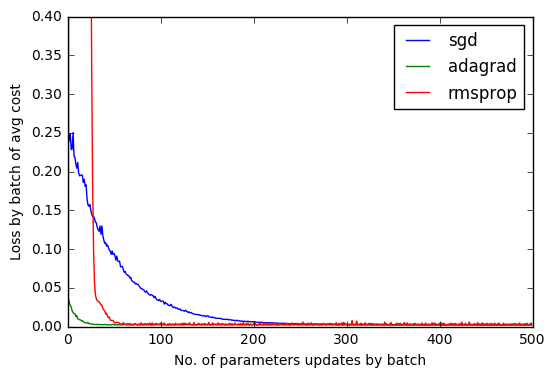

In [10]:
###############################################################################
### cost chart
plt.plot(his_cost_by_gd.iloc[:, 0], label='sgd')
plt.plot(his_cost_by_adagd.iloc[:, 0], label='adagrad')
plt.plot(his_cost_by_rmsprop.iloc[:, 0], label='rmsprop')
plt.legend()
plt.xlabel("No. of parameters updates by batch")
plt.ylabel("Loss by batch of avg cost")
plt.ylim([0, 0.4])
plt.show()

## RMSProp比起Sgd/Adagrad一開始的時候cost特別高，但是之後下降地特別快

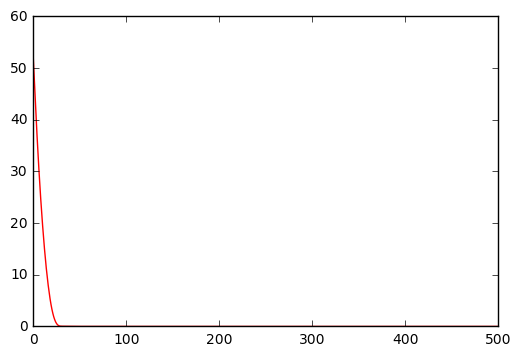

In [12]:
plt.plot(his_cost_by_rmsprop.iloc[:, 0], 'r-', label='rmsprop')
plt.show()